In [1]:
# import dataiku
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
from numerize import numerize

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append("C:/Users/w510663/Desktop/Pyri/connections/")
from conn import snowflake_conn

# Get execution time
st = time.time()

conn = snowflake_conn()
cur = conn.cursor()

# Original dataset can be found in the following table
## SANDBOX.BCG_ENG__W510663.RDS_NAF_PM_EXCL_ACCOUNTS
## SANDBOX.BCG_ENG__W510663.RDS_NAF_PM_EXCL_ACCOUNTS_RETRAIN_SCORING

cur.execute('''
    SELECT SCR.*, EXCL.CR_LIMIT
    FROM "DATAIKU_ANALYTICS_SUB"."RISK_FRAUD"."RDS_NAF_PM_EXCL_ACCOUNTS_RETRAIN_SCORING" SCR
    LEFT JOIN "DATAIKU_ANALYTICS_SUB"."RISK_FRAUD"."RDS_NAF_PM_EXCL_ACCOUNTS" EXCL
     ON SCR.CUST_ID = EXCL.CUST_ID AND SCR.SETID = EXCL.SETID AND SCR.REF_DATE = EXCL.REF_DATE
    WHERE YEAR(SCR.REF_DATE) IN (2021,2022)
    AND SCR.REF_DATE::DATE NOT IN ('2021-04-01', '2021-08-01')
;
''')
retrain_df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

et = time.time()
elapsed_time = et - st
print('Data Shape:', retrain_df.shape, 
      '\nExecution time:', elapsed_time / 60, 'minutes')

retrain_df.head()

Failed to import ArrowResult. No Apache Arrow result set format can be used. ImportError: DLL load failed while importing arrow_iterator: The specified procedure could not be found.


Data Shape: (5686082, 37) 
Execution time: 3.9615114172299704 minutes


,CUST_ID,SETID,REF_DATE,A_NAICS_2_DIGIT_C,A_TENURE_MONTHS_N,A_FLAG_REVOLVER_B,A_YEARS_IN_BUSINESS_APP_N,A_FLEET_SIZE_APP_N,D_SPREAD_EXPOSURE_6M_N,D_MAX_DAYS_PAST_DUE_6M_N,...,FLAG_90_DPD_366_DAYS,A_BUSINESS_PROGRAM_C,A_MARKETING_CHANNEL_C,FLAG_CHARGEOFF_366_DAYS,A_PORTFOLIO_C,EXCL_FLAG_GROUP,proba_0,proba_1,prediction,CR_LIMIT
0,9100008364789,WXB,2022-06-01 00:00:00-07:00,56,23,0,NaN,18.0,0.173052,0.0,...,0,Shell Fleet Navigator,Acquire,0,WXB,Inclusion,0.995471,0.004529,0,16000.00
1,6300017870157,IOL,2022-06-01 00:00:00-07:00,Un,166,0,NaN,NaN,1.170671,15.0,...,0,Imperial Oil,None,0,IOL,Large Credit Limit,0.993475,0.006525,0,1504363.37
2,9100007243137,FSC,2022-06-01 00:00:00-07:00,62,38,0,33.0,1.0,1.959739,15.0,...,0,Circle K Fleet,Website,0,FSC,Inclusion,0.969080,0.030920,0,500.00
3,6300013248366,IOL,2022-06-01 00:00:00-07:00,Un,345,0,NaN,NaN,0.934266,13.0,...,0,Imperial Oil,None,0,IOL,Large Credit Limit,0.995374,0.004626,0,1504363.37
4,9100003461814,FSC,2022-06-01 00:00:00-07:00,56,84,0,NaN,7.0,0.511381,0.0,...,0,ExxonMobil Universal,Generic,0,FSC,EFPS,0.999617,0.000383,0,36500.00


In [4]:
# Drop model unused from the dataset
cols_to_drop = ['SETID', 'A_BUSINESS_PROGRAM_C', 'A_MARKETING_CHANNEL_C', 'A_PORTFOLIO_C',
                'FLAG_90_DPD_366_DAYS', 'FLAG_CHARGEOFF_366_DAYS', 'proba_0',
                # 'EXCL_PORTFOLIO_FLAG', 'EXCL_CUST_STATUS_FLAG', 'EXCL_CUST_TENURE_FLAG',
                # 'EXCL_DUMMY_CREDIT_LIMIT_FLAG', 'EXCL_MATERIAL_DELINQUENCY_FLAG',
                # 'EXCL_CUST_CONVERSION_FLAG', 'EXCL_FRAUD_FLAG', 'WX_CR_RATING_DATE_TO_REF_DATE', 'EARLIEST_ACTIVE_DATE_TO_REF_DATE',
                # 'ALL_EXCL_FLAGS_SUM', 'RETRAIN_EXCL_FLAGS_SUM',
                # 'EXCL_GOV_VIP_FLAG', 'EXCL_LARGE_CREDIT_LIMIT_FLAG', 'EXCL_EFPS_FLAG', 'WX_CUST_SUSP_CLASS', 'GOVERNMENT_FLG',
                # 'BUSINESS_MONTH', 'BUSINESS_DATE', 'BUSINESS_DATE_TO_LINK', 'WX_AGE99', 'WX_EIPP_BALANCE',
]

cols_rename_map = {'CUST_ID': 'ID',
                   'FLAG_60_DPD_366_DAYS': 'target',
                   'proba_1': 'y_pred_proba',
                   'prediction': 'y_pred',
}


retrain = retrain_df.drop(cols_to_drop, axis=1)
retrain.rename(cols_rename_map, axis=1, inplace=True)

incl = retrain[(retrain['EXCL_FLAG_GROUP'] == 'Inclusion') & (retrain['CR_LIMIT'] < 150000)]
gov = retrain[retrain['EXCL_FLAG_GROUP'] == 'GOV']
vip = retrain[retrain['EXCL_FLAG_GROUP'] == 'VIP']
efps = retrain[retrain['EXCL_FLAG_GROUP'] == 'EFPS']
at_150k = retrain[(retrain['EXCL_FLAG_GROUP'] == 'Inclusion') & (retrain['CR_LIMIT'] == 150000)]
at_150k['EXCL_FLAG_GROUP'] = '150k Credit Limit'
over_150k = retrain[(retrain['EXCL_FLAG_GROUP'] == 'Large Credit Limit') & (retrain['CR_LIMIT'] > 150000)] 

# print out the shape of each dataframe
print('Inclusion:', incl.shape)
print('Government:', gov.shape)
print('VIP:', vip.shape)
print('EPFS:', efps.shape)
print('$150k Credit Limit:', at_150k.shape)
print('Over $150k Credit Limit:', over_150k.shape)

Inclusion: (5108662, 30)
Government: (230315, 30)
VIP: (46859, 30)
EPFS: (254926, 30)
$150k Credit Limit: (14515, 30)
Over $150k Credit Limit: (30805, 30)


In [5]:
# union all dataframes
df_combine = pd.concat([incl, gov, vip, efps, at_150k, over_150k])
df_combine.head()

,ID,REF_DATE,A_NAICS_2_DIGIT_C,A_TENURE_MONTHS_N,A_FLAG_REVOLVER_B,A_YEARS_IN_BUSINESS_APP_N,A_FLEET_SIZE_APP_N,D_SPREAD_EXPOSURE_6M_N,D_MAX_DAYS_PAST_DUE_6M_N,D_MAX_EXPOSURE_1M_N,...,T_TOTAL_TRX_NON_FUEL_PROPORTION_1M_N,T_SPREAD_GROSS_SPEND_6M_N,T_SPREAD_TOTAL_TRX_6M_N,T_SUM_GALLONS_1M_N,T_SPREAD_SUM_GALLONS_6M_N,target,EXCL_FLAG_GROUP,y_pred_proba,y_pred,CR_LIMIT
0,9100008364789,2022-06-01 00:00:00-07:00,56,23,0,NaN,18.0,0.173052,0.0,5785.46,...,0.050847,0.360997,0.420779,1060.472,0.405012,0,Inclusion,0.004529,0,16000.00
2,9100007243137,2022-06-01 00:00:00-07:00,62,38,0,33.0,1.0,1.959739,15.0,92.05,...,0.500000,3.792494,3.000000,10.206,3.954231,0,Inclusion,0.030920,0,500.00
5,9100008560035,2022-06-01 00:00:00-07:00,44,20,1,6.0,1.0,1.829108,0.0,167.75,...,0.000000,1.976306,1.846154,54.940,2.054318,0,Inclusion,0.011422,0,500.00
7,9100004528422,2022-06-01 00:00:00-07:00,56,56,0,25.0,4.0,1.379640,0.0,400.29,...,1.000000,2.085467,1.943182,0.000,2.025198,1,Inclusion,0.106507,0,7700.00
8,9100006360120,2022-06-01 00:00:00-07:00,23,43,1,9.0,3.0,0.273051,4.0,3333.35,...,0.000000,0.606897,0.878049,176.490,0.747303,0,Inclusion,0.018603,0,3900.00


### Overall Number of Accounts and Default Rate by Group

In [ ]:
grouped = df_combine.groupby(['EXCL_FLAG_GROUP'])['target'].agg(['count', 'mean']).reset_index()
grouped.columns = ['Group', 'Number of Accounts', 'Default Rate']

# order by manual index
grouped = grouped.reindex([3, 2, 5, 1, 4, 0]).reset_index()
# grouped = grouped.sort_values(by='Number of Accounts', ascending=False).reset_index()

grouped

,index,Group,Number of Accounts,Default Rate
0,3,Inclusion,5108662,0.061608
1,2,GOV,230315,0.046050
2,5,VIP,46859,0.009753
3,1,EFPS,254926,0.000930
4,4,Large Credit Limit,30805,0.008765
5,0,150k Credit Limit,14515,0.027420


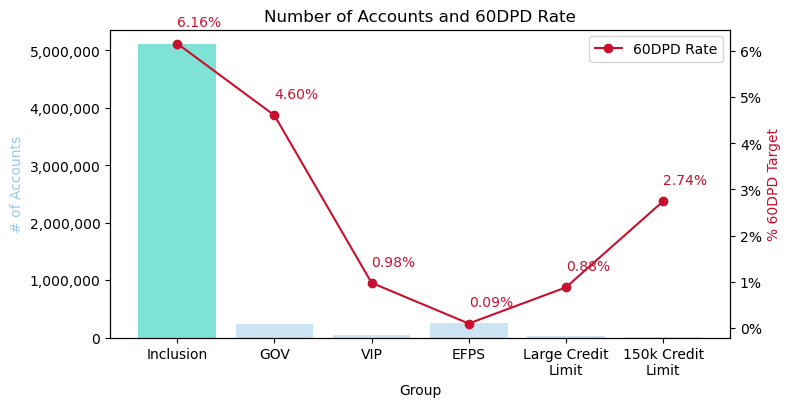

In [ ]:
from textwrap import wrap

# Create a combination chart
fig, ax1 = plt.subplots(figsize=(8, 4))

ax2 = ax1.twinx()
ax1.bar(grouped.index, grouped['Number of Accounts'], color=['#9bcbeb' if i >= 1 else '#00c7b1' for i in grouped.index], alpha=0.5, label='Total')
ax2.plot(grouped.index, grouped['Default Rate'] * 100, color='#c8102e', marker='o', label='60DPD Rate')

ax1.set_xlabel('Group')
ax1.set_ylabel('# of Accounts', color='#9bcbeb')
# y label format as number with comma
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax2.set_ylabel('% 60DPD Target', color='#c8102e')
# y label format as percent with 0 decimal place
ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))

# data label on ax2 as percent with 1 decimal place
for i, v in enumerate(grouped['Default Rate']):
    ax2.text(i, v * 100 + 0.3, "{:.2f}%".format(v * 100), color='#c8102e', ha='left', va='bottom')


plt.xticks(grouped.index, grouped['Group'])
# rotate xticks
# plt.setp(ax1.xaxis.get_majorticklabels(), rotation=65)

labels = [ '\n'.join(wrap(l, 15)) for l in grouped['Group']]
ax1.set_xticklabels(labels)

plt.title('Number of Accounts and 60DPD Rate')
plt.legend(loc='upper right')
plt.show()

### Organize the datasets into a dictionary
This approach facilitates efficient access and manipulation.

In [ ]:
df_flags = df_combine['EXCL_FLAG_GROUP'].unique()

# convert string to lowercase and replace space and / with underscore
converter = lambda x: x.lower().replace(" ", "_").replace("/", "_")
df_names = list(map(converter, df_flags))
print(df_names)

['inclusion', 'gov', 'vip', 'efps', '150k_credit_limit', 'large_credit_limit']


In [ ]:
all_acct = df_combine.copy()

# Split data into inclusion/exclusion flags
df_list = {}

for e,l in zip(df_flags, df_names):
    d = all_acct.loc[all_acct['EXCL_FLAG_GROUP'] == e]
    d = d.drop(['EXCL_FLAG_GROUP'], axis=1)
    df_list[l] = d
    # Print each dataframe shape
    print(l, 'shape: ', df_list[l].shape)

inclusion shape:  (5108662, 29)
gov shape:  (230315, 29)
vip shape:  (46859, 29)
efps shape:  (254926, 29)
150k_credit_limit shape:  (14515, 29)
large_credit_limit shape:  (30805, 29)


### Calculate ROC-AUC, Presicion, Recall, and F1 Score

In [ ]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve

fpr = {}
tpr = {}
fpr_tpr_threshold = {}
roc_auc = {}
precision = {}
recall = {}
f1 = {}
precision_recall_threshold = {}
pr_auc = {}

for i,j in zip(df_list, df_flags):
    # Calculate ROC curve and AUC
    fpr[j], tpr[j], fpr_tpr_threshold[j] = roc_curve(df_list[i]['target'], df_list[i]['y_pred_proba'])
    roc_auc[j] = auc(fpr[j], tpr[j])

    # Calculate precision-recall curve and AUC
    precision[j], recall[j], precision_recall_threshold[j] = precision_recall_curve(df_list[i]['target'], df_list[i]['y_pred_proba'])
    pr_auc[j] = auc(recall[j], precision[j])
    f1[j] = 2*precision[j]*recall[j]/(precision[j]+recall[j])

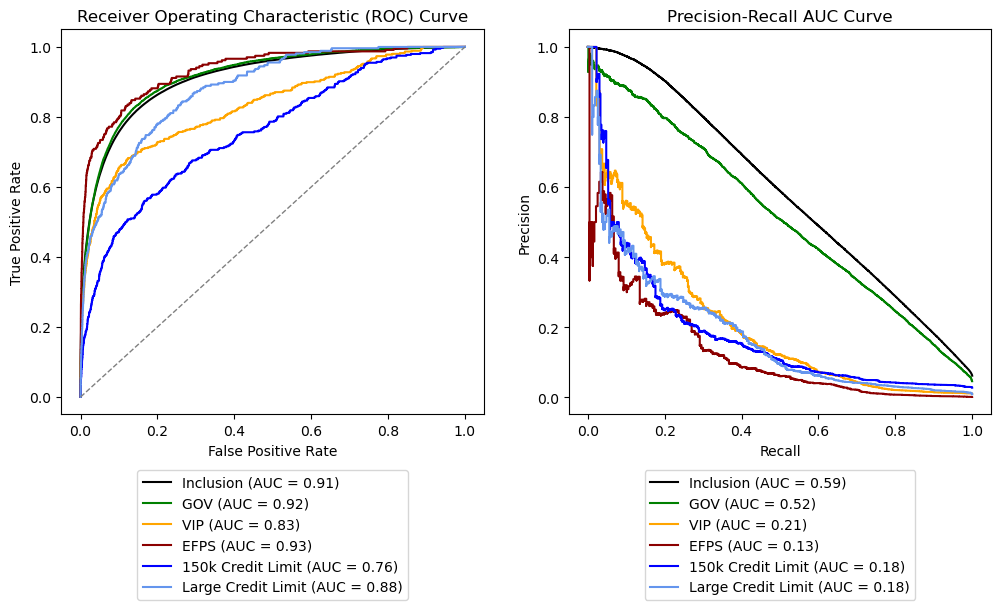

In [ ]:
# Plot ROC-AUC and PR-AUC side by side
plt.figure(figsize=(12, 5))

colors = ['black', 'green', 'orange', 'darkred', 'blue', 'cornflowerblue']
lines = []
lines2 = []
to_plot = df_flags

plt.subplot(1, 2, 1)
for p,c in zip(to_plot, colors):
    lines += plt.plot(fpr[p], tpr[p], color=c, lw=1.5, label=f'{p} (AUC = {roc_auc[p]:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
labels = [l.get_label() for l in lines]
# plot legend outside of plot
plt.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.5))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.subplot(1, 2, 2)
for p,c in zip(to_plot, colors):
    lines2 += plt.step(recall[p], precision[p], color=c, where='post', label=f'{p} (AUC = {pr_auc[p]:.2f})')
labels2 = [l.get_label() for l in lines2]
# move legend to lower center outside of plot
plt.legend(lines2, labels2, loc='lower center', bbox_to_anchor=(0.5, -0.5))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall AUC Curve')

# plt.tight_layout()
plt.show()

In [ ]:
def calculate_decile_table(binded, bins):
    result = []

    binded = binded.sort_values("y_pred_proba", ascending = False)
    binded["DECILE"] = pd.qcut(binded["y_pred_proba"].rank(method='first'), q = bins, labels = list(range(bins, 0, -1)))
    binded["TOTAL_EVENT_RATE"] =  binded["target"].mean()

    # Calculate the number of accounts and default accounts for each decile
    decile_df = binded.groupby("DECILE").agg(
        COUNT=("y_pred_proba", "count"),
        DEFAULT=("target", "sum"),
        TOTAL_EVENT_RATE=("TOTAL_EVENT_RATE", "mean"),
    ).reset_index()

    # Calculate the predicted probability range for each decile
    decile_df["PROB_RANGE"] = binded.groupby("DECILE")["y_pred_proba"].agg(["min", "max"]).apply(lambda x: f"({x['min']:.4f} - {x['max']:.4f}]", axis=1).values
    decile_df["AVG_PROB"] = binded.groupby("DECILE")["y_pred_proba"].agg(["mean"]).values
    decile_df["AVG_PROB"] = round(decile_df["AVG_PROB"], 4)

    # sort dataframes by decile
    decile_df = decile_df.sort_values(by="DECILE", ascending=False)

    # Calculate the cumulative number of accounts and default accounts
    decile_df["CUM_COUNT"] = round(decile_df["COUNT"].cumsum(),0)
    decile_df["CUM_DEFAULT"] = decile_df["DEFAULT"].cumsum()

    # Calculate the cumulative percentage of accounts and default accounts
    decile_df["CUM_PCT_COUNT"] = round(decile_df["CUM_COUNT"] / decile_df["COUNT"].sum() * 100, 3)
    decile_df["CUM_PCT_DEFAULT"] = round((decile_df["CUM_DEFAULT"] / decile_df["DEFAULT"].sum()), 3)

    # Calculate the default rate for each decile
    decile_df["DEFAULT_RATE"] = round((decile_df["DEFAULT"] / decile_df["COUNT"]), 3)

    # Calculate gain for each decile
    decile_df["GAIN"] = round((decile_df["CUM_DEFAULT"] / binded["target"].sum()), 3)

    # Calculate the lift for each decile
    decile_df["LIFT"] = round((decile_df["GAIN"]*100) / (decile_df["CUM_PCT_COUNT"]), 3)

    cols_to_display = [
        "DECILE", "PROB_RANGE", "AVG_PROB", "COUNT", "DEFAULT_RATE", "TOTAL_EVENT_RATE", "CUM_COUNT", "CUM_DEFAULT", "CUM_PCT_DEFAULT",
        "GAIN", "LIFT"
    ]

    decile_df = decile_df[cols_to_display]

    return decile_df


def lift_curve(name, df_binned):
    event_rate = df_binned["TOTAL_EVENT_RATE"].astype(float).mean()

    # Build event rate plot
    fig = plt.figure(figsize=(12,4))

    # Plot barplot containing number of observations
    plt.bar(df_binned.index, df_binned["COUNT"], color="lightgray")

    # Add ticks & laels to axis
    plt.xlabel("Model Sorted Predictions (Low → High)")
    plt.ylabel("# Observations")
    plt.xticks(df_binned.index, df_binned["PROB_RANGE"], rotation=45, ha='right', rotation_mode='anchor')
    plt.title(f"Actual vs. Predicted Lift Chart ({name})")

    # Mirror plot and add event rates
    plt2 = plt.twinx()
    plt2.set_ylabel("Event rate")
    plt2.set_ylim(ymin=0, ymax=df_binned["DEFAULT_RATE"].max() + 0.1)
    plt2.set_yticks(np.arange(0, df_binned["DEFAULT_RATE"].max() + 0.1, step=0.05))
    plt2.plot(
        df_binned.index, df_binned["DEFAULT_RATE"], label="event_rate", marker="o"
    )

    # add average prediction
    plt2.plot(
        df_binned.index,
        df_binned["AVG_PROB"],
        label="average_prediction",
        marker="x",
        linestyle=":",
        color="black"
    )

    # Add global event rate as baseline
    plt2.plot(
        [min(df_binned.index) - 1, max(df_binned.index) + 1],
        [event_rate, event_rate],
        color="darkgrey",
        lw=1,
        linestyle="--",
        label=f"total_event_rate\n({'{:.1%}'.format(event_rate)})",
    )
    plt2.legend(loc=0)
    plt2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    plt2.yaxis.grid(False)
    plt2.set_xlim([min(df_binned.index) - 0.5, max(df_binned.index) + 0.5])

    plt.show()

In [ ]:
def split_data_by_year(df):
    df_by_year = {}
    year = ['2021', '2022_1h', '2022_2h']

    # change ref_date to date
    df['REF_DATE'] = pd.to_datetime(df['REF_DATE'], format='%Y-%m-%d %H:%M:%S', utc=True)

    # create datafram call df_2021 which have ref_date in 2021
    df_2021 = df[df['REF_DATE'].dt.year == 2021]
    print(df_2021.shape)

    # create datafram call df_2022_1h which have ref_date in 1st half of the year 2022
    df_2022_1h = df[(df['REF_DATE'].dt.year == 2022) & (df['REF_DATE'].dt.month <= 6)]
    df_2022_2h = df[(df['REF_DATE'].dt.year == 2022) & (df['REF_DATE'].dt.month > 6)]
    print(df_2022_1h.shape, df_2022_2h.shape)
    
    df_by_year[year[0]] = df_2021
    df_by_year[year[1]] = df_2022_1h
    df_by_year[year[2]] = df_2022_2h

    return df_by_year

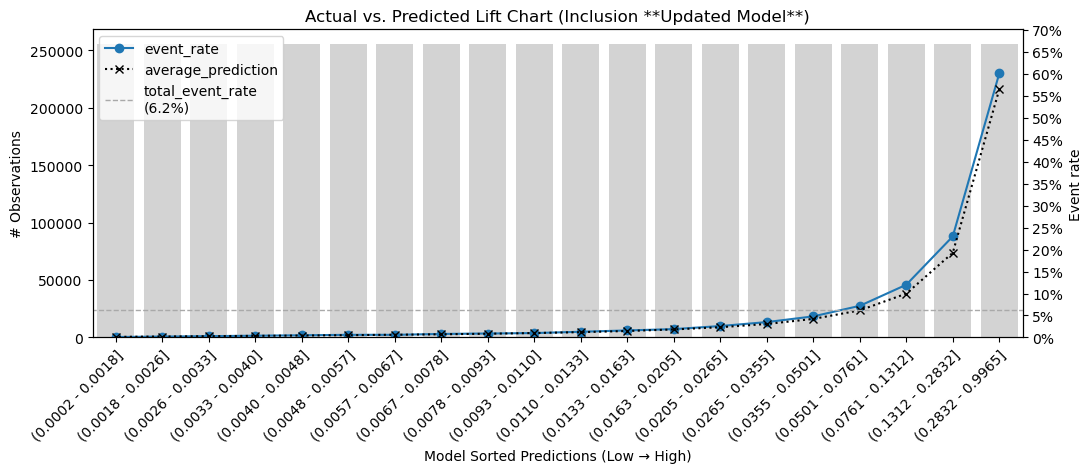

In [ ]:
lift_curve(f'Inclusion **Updated Model**', calculate_decile_table(incl, 20))

(1234773, 30)
(1937075, 30) (1936814, 30)


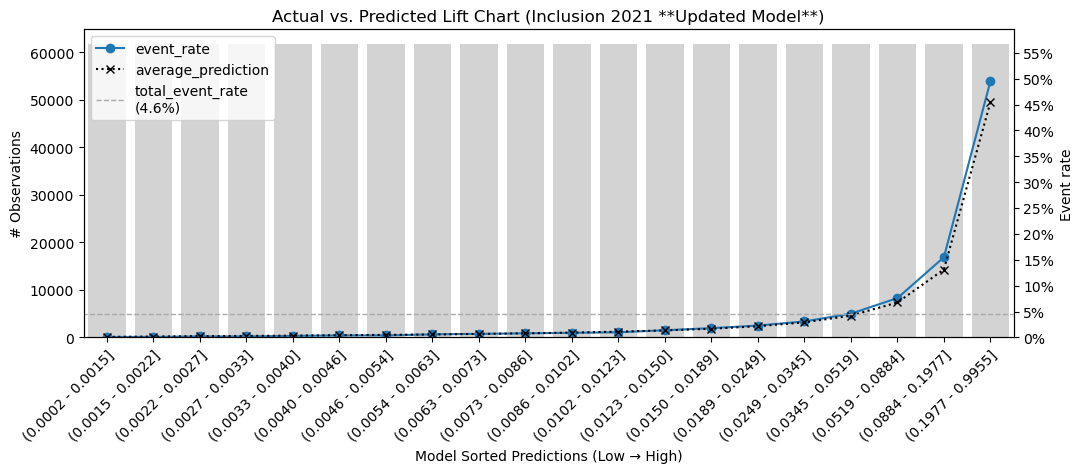

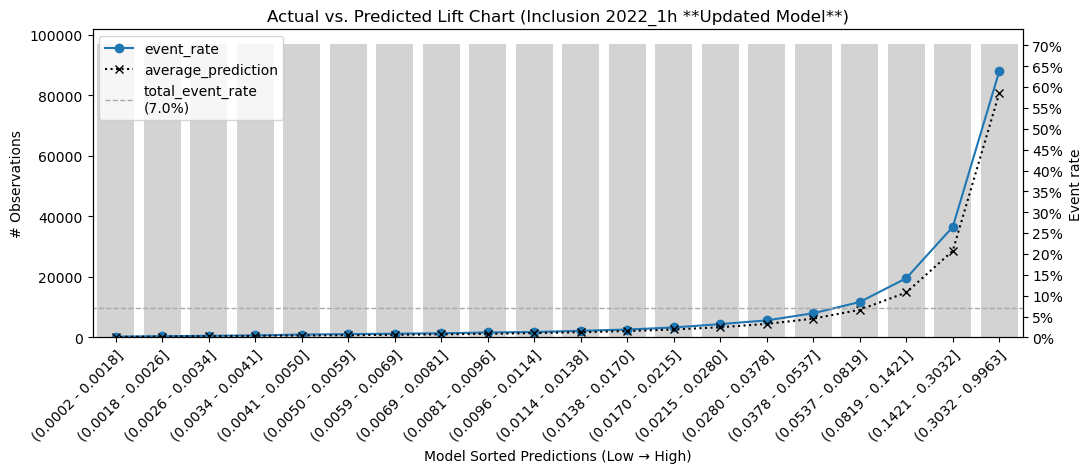

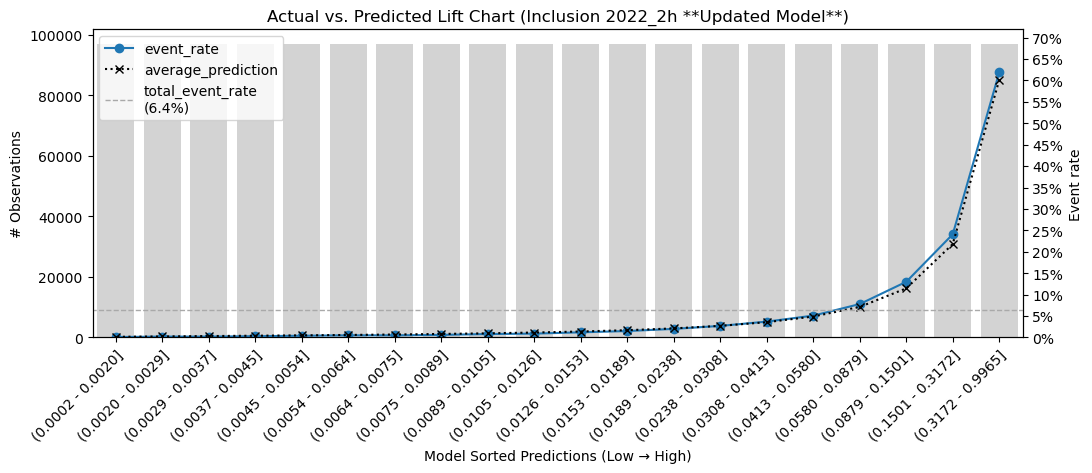

In [ ]:
incl_by_year = split_data_by_year(incl)

for y in incl_by_year:
    lift_curve(f'Inclusion {y} **Updated Model**', calculate_decile_table(incl_by_year[y], 20))

In [ ]:
def metrics_by_year(df_by_year):
    for y in df_by_year:
        fpr, tpr, threshold = roc_curve(df_by_year[y]['target'], df_by_year[y]['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        precision, recall, precision_recall_threshold = precision_recall_curve(df_by_year[y]['target'], df_by_year[y]['y_pred_proba'])
        pr_auc = auc(recall, precision)
        f1 = 2*precision*recall/(precision+recall)
        print(f'{y} - Count: {df_by_year[y].shape[0]} \nROC AUC: {roc_auc:.2f}\nPR AUC: {pr_auc:.2f}')

metrics_by_year(incl_by_year)

2021 - Count: 1234773 
ROC AUC: 0.92
PR AUC: 0.55
2022_1h - Count: 1937075 
ROC AUC: 0.90
PR AUC: 0.59
2022_2h - Count: 1936814 
ROC AUC: 0.92
PR AUC: 0.60


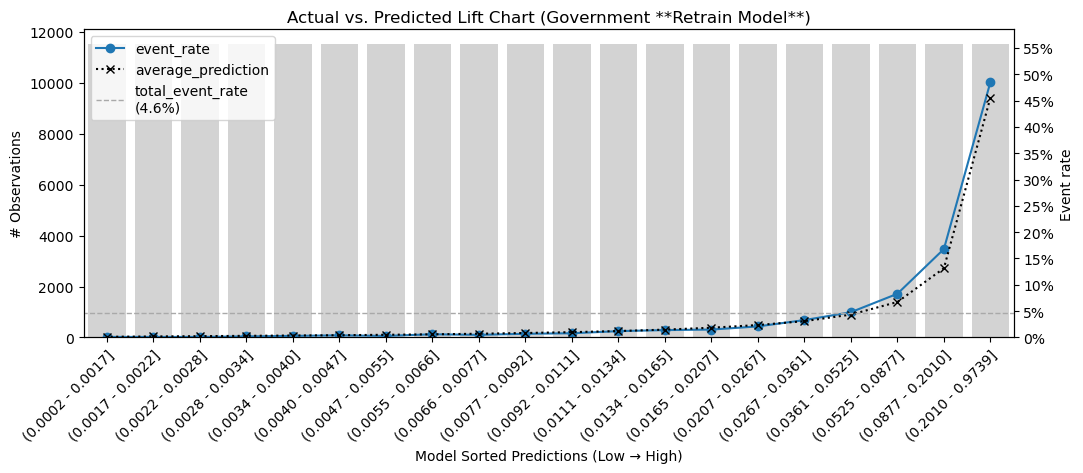

In [ ]:
lift_curve(f'Government **Retrain Model**', calculate_decile_table(gov, 20))

(54633, 30)
(86967, 30) (88715, 30)


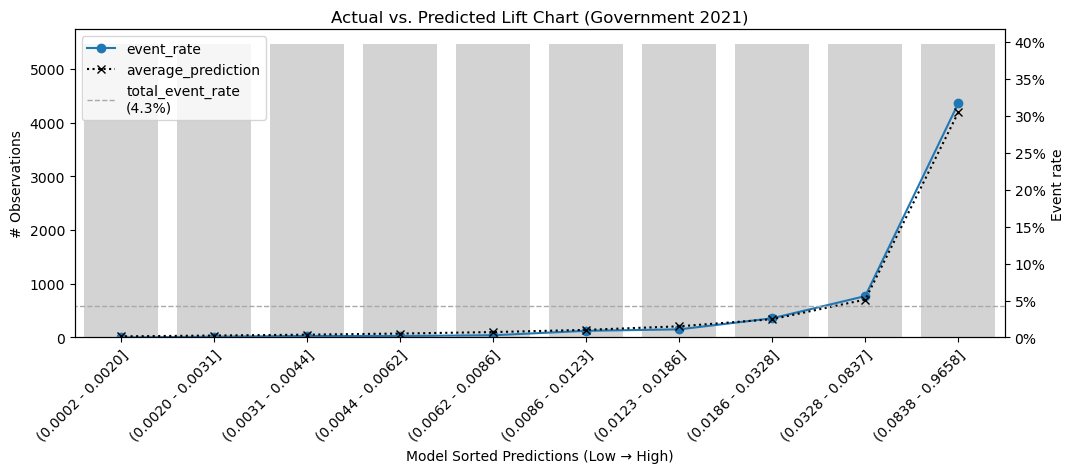

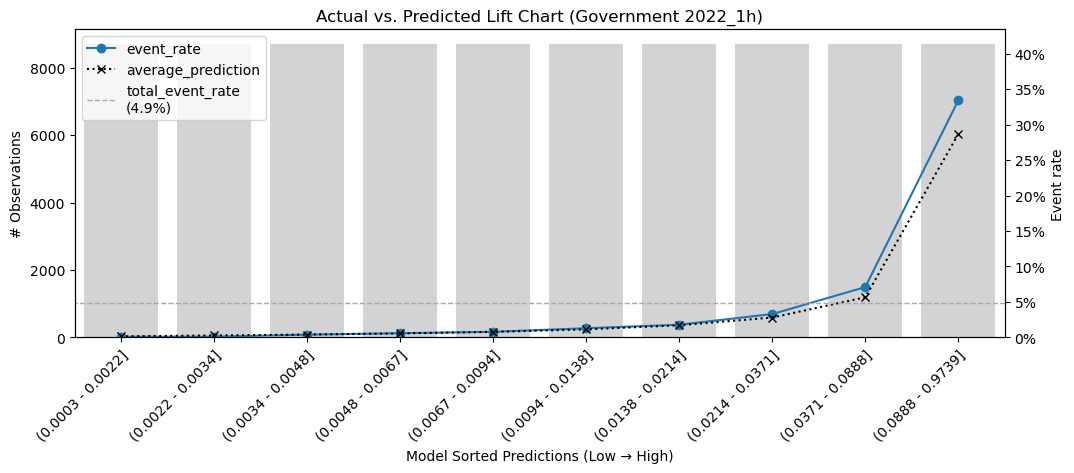

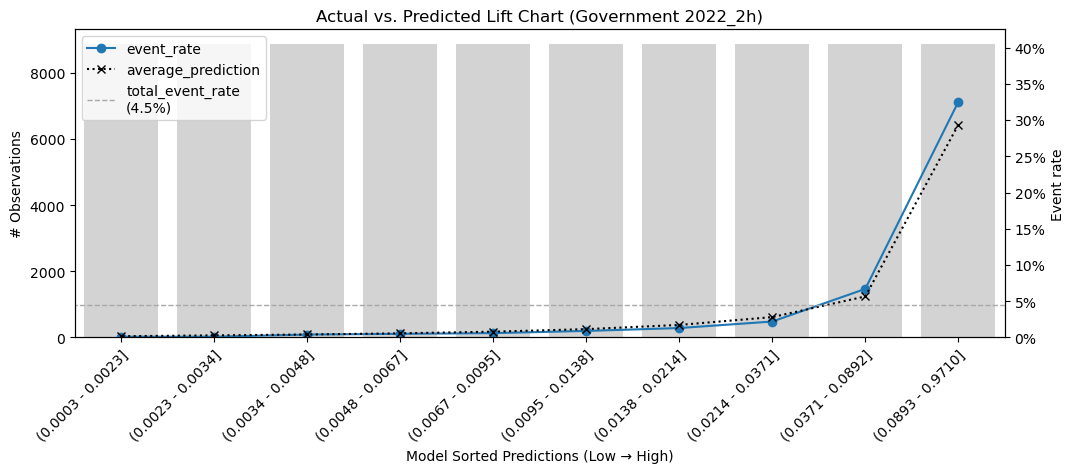

In [ ]:
gov_by_year = split_data_by_year(gov)

for y in gov_by_year:
    lift_curve(f'Government {y}', calculate_decile_table(gov_by_year[y], 10))

In [ ]:
metrics_by_year(gov_by_year)

2021 - Count: 54633 
ROC AUC: 0.93
PR AUC: 0.55
2022_1h - Count: 86967 
ROC AUC: 0.91
PR AUC: 0.49
2022_2h - Count: 88715 
ROC AUC: 0.92
PR AUC: 0.52


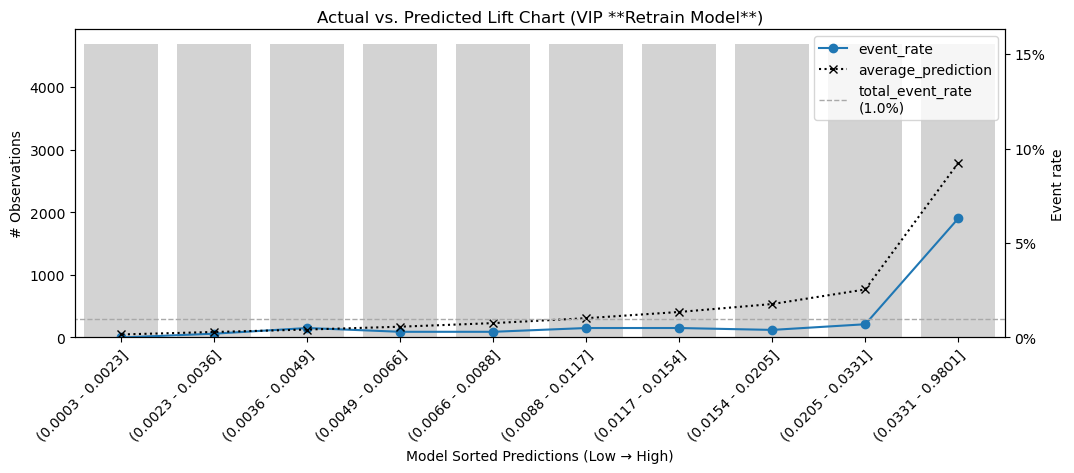

In [ ]:
lift_curve(f'VIP **Retrain Model**', calculate_decile_table(vip, 10))

(10717, 30)
(17222, 30) (18920, 30)


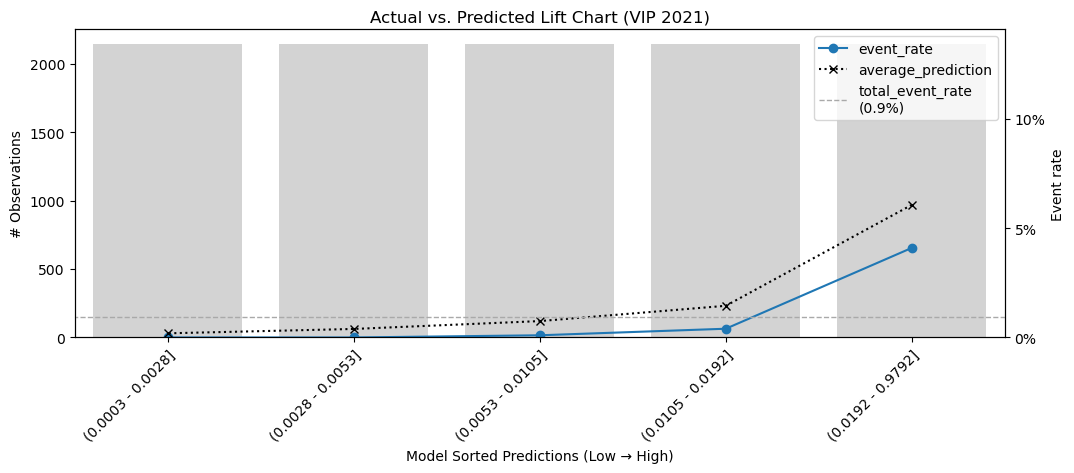

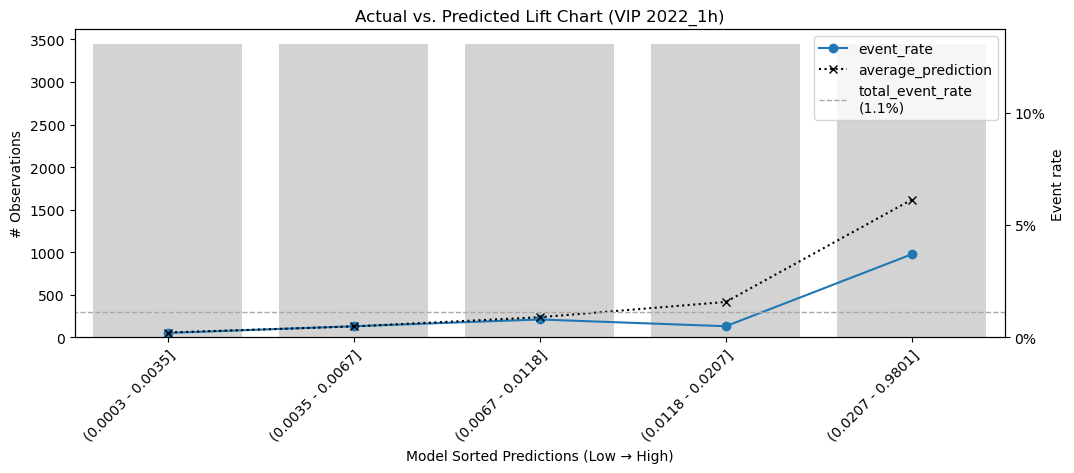

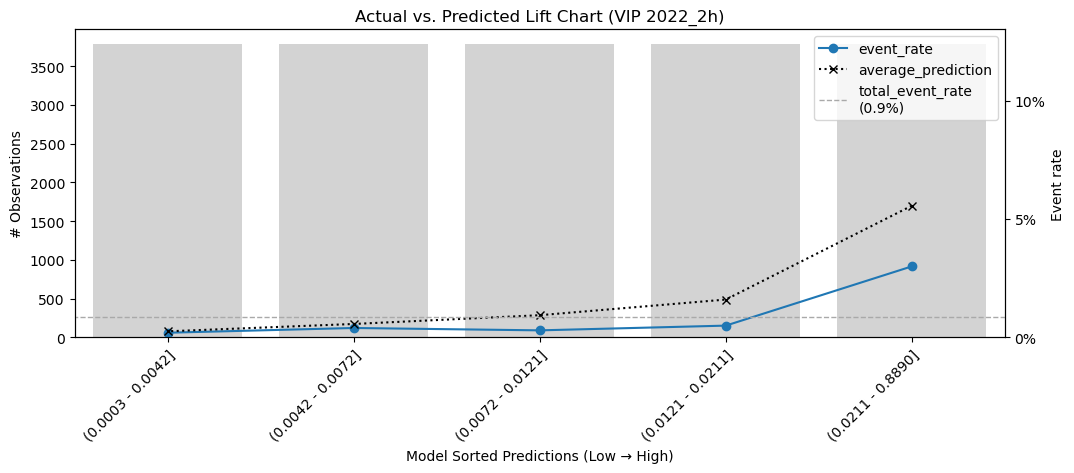

In [ ]:
vip_by_year = split_data_by_year(vip)

for y in vip_by_year:
    lift_curve(f'VIP {y}', calculate_decile_table(vip_by_year[y], 5))

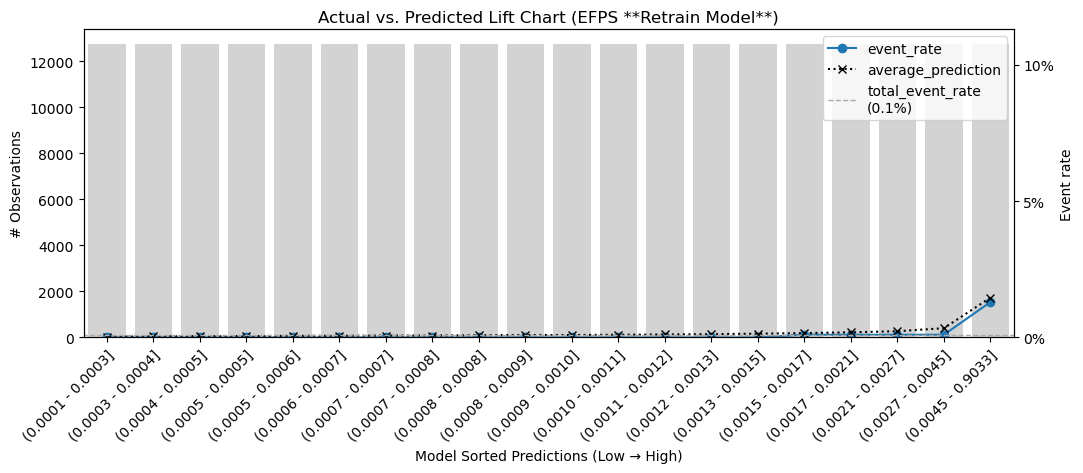

In [ ]:
lift_curve(f'EFPS **Retrain Model**', calculate_decile_table(efps, 20))

In [ ]:
metrics_by_year(vip_by_year)

2021 - Count: 10717 
ROC AUC: 0.93
PR AUC: 0.27
2022_1h - Count: 17222 
ROC AUC: 0.79
PR AUC: 0.19
2022_2h - Count: 18920 
ROC AUC: 0.81
PR AUC: 0.21


(55616, 30)
(92853, 30) (106457, 30)
2021 - Count: 55616 
ROC AUC: 0.87
PR AUC: 0.06
2022_1h - Count: 92853 
ROC AUC: 0.95
PR AUC: 0.09
2022_2h - Count: 106457 
ROC AUC: 0.97
PR AUC: 0.24


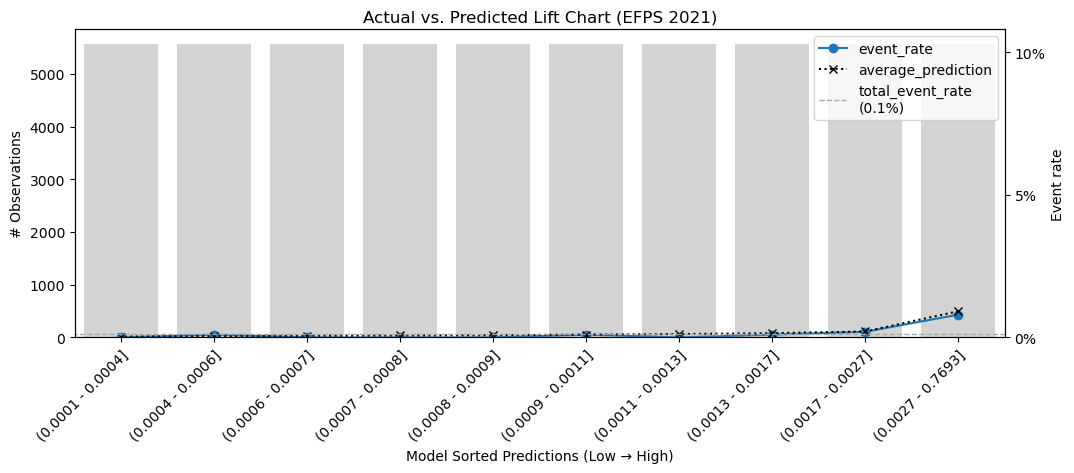

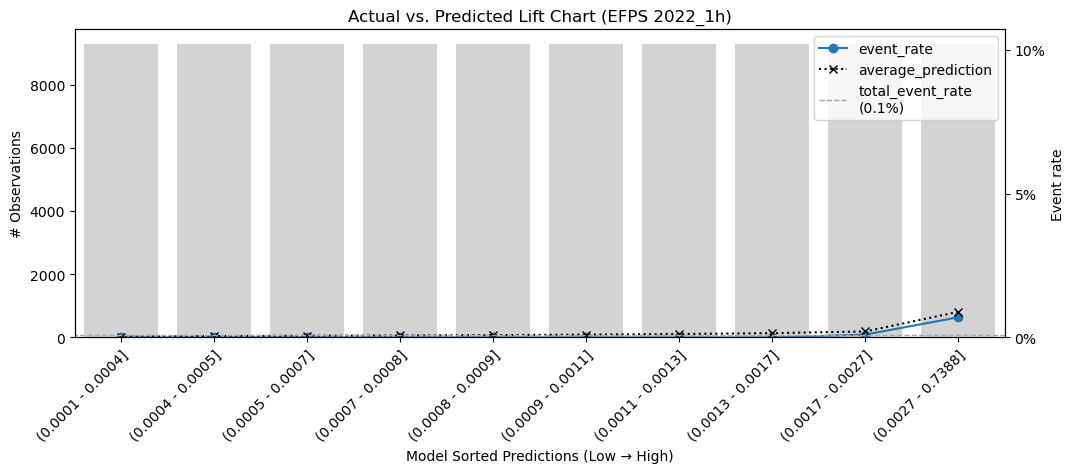

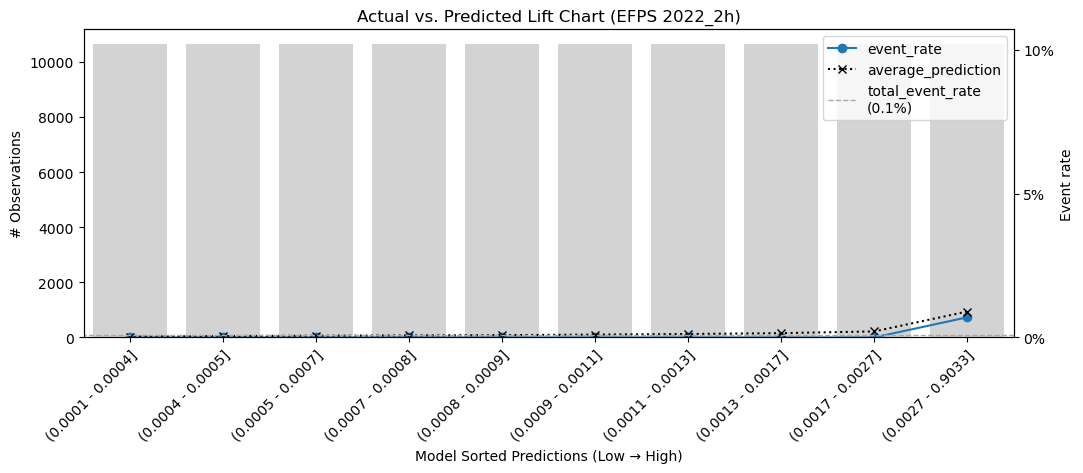

In [ ]:
efps_by_year = split_data_by_year(efps)

metrics_by_year(efps_by_year)

for y in efps_by_year:
    lift_curve(f'EFPS {y}', calculate_decile_table(efps_by_year[y], 10))

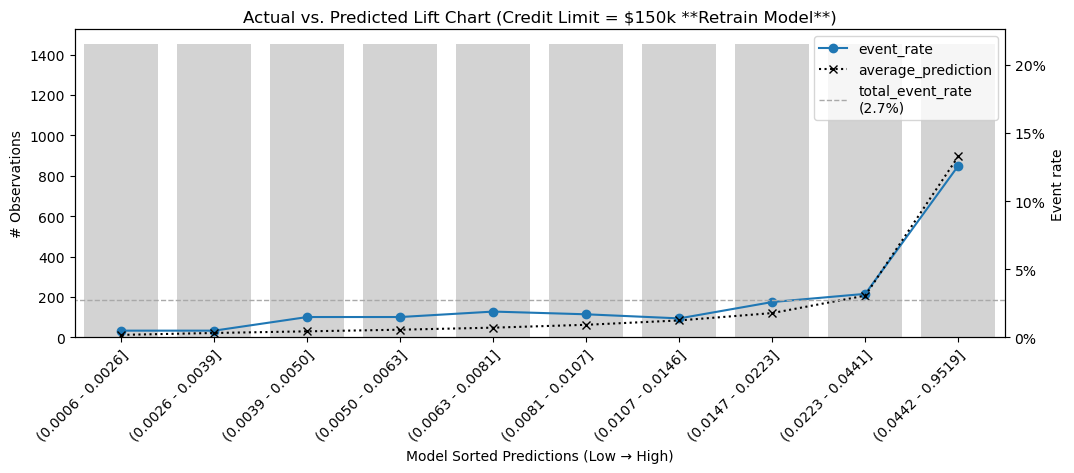

In [ ]:
lift_curve(f'Credit Limit = $150k **Retrain Model**', calculate_decile_table(at_150k, 10))

(1553, 30)
(4504, 30) (8458, 30)
2021 - Count: 1553 
ROC AUC: 0.89
PR AUC: 0.34
2022_1h - Count: 4504 
ROC AUC: 0.69
PR AUC: 0.13
2022_2h - Count: 8458 
ROC AUC: 0.78
PR AUC: 0.20


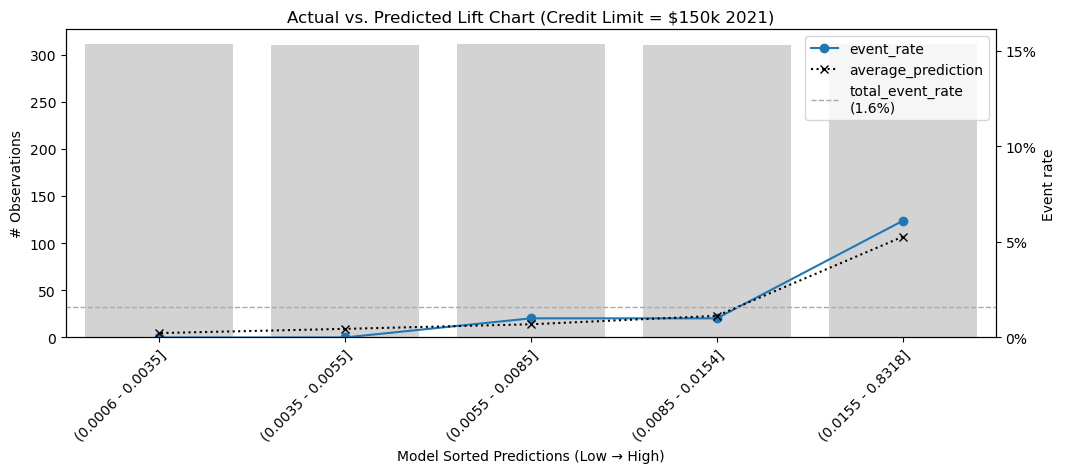

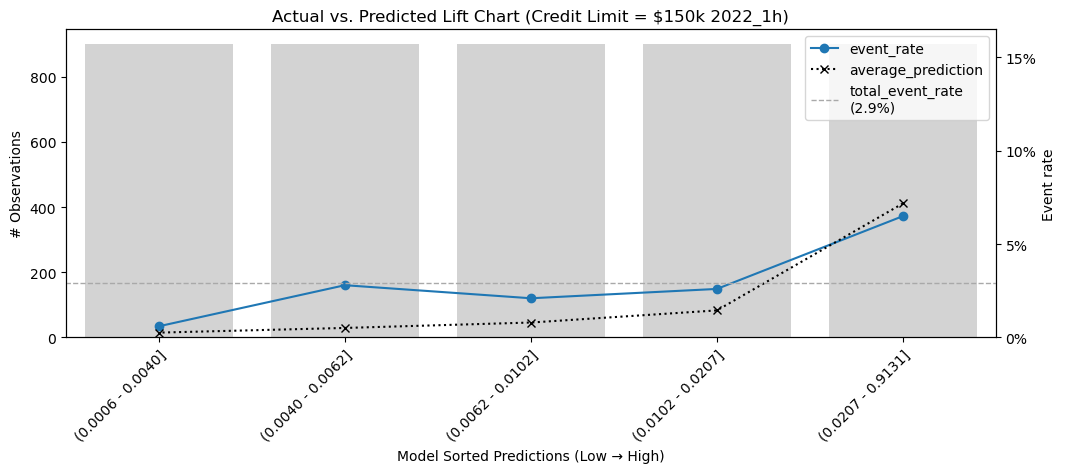

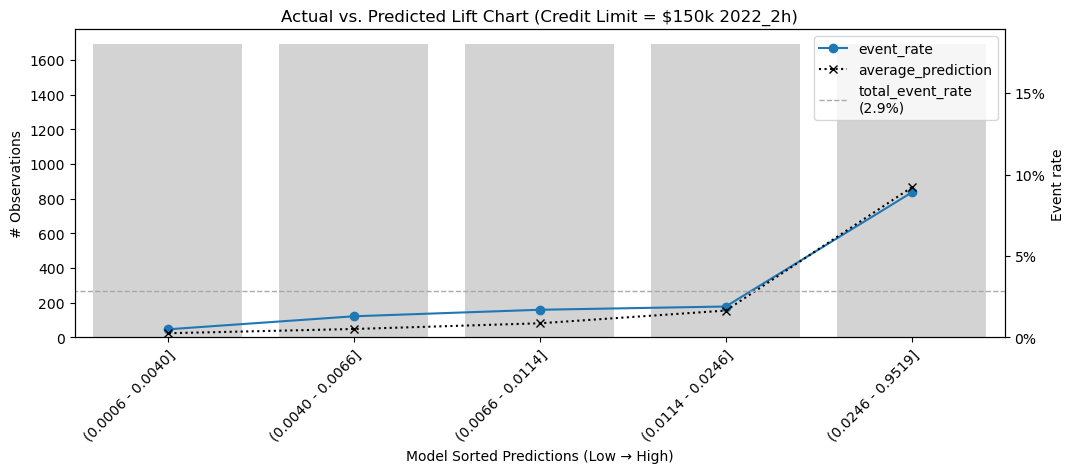

In [ ]:
at_150k_by_year = split_data_by_year(at_150k)

metrics_by_year(at_150k_by_year)

for y in at_150k_by_year:
    lift_curve(f'Credit Limit = $150k {y}', calculate_decile_table(at_150k_by_year[y], 5))

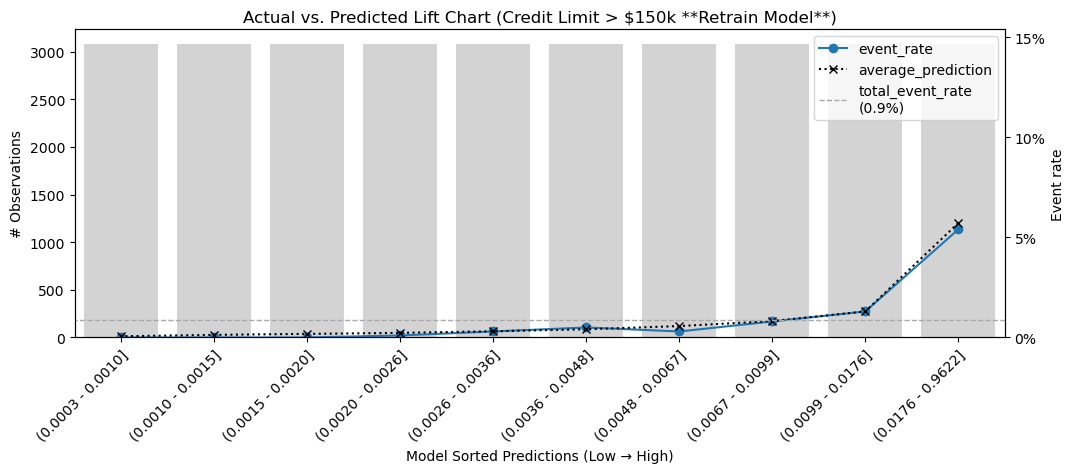

In [ ]:
lift_curve(f'Credit Limit > $150k **Retrain Model**', calculate_decile_table(over_150k, 10))

(7981, 30)
(11231, 30) (11593, 30)
2021 - Count: 7981 
ROC AUC: 0.96
PR AUC: 0.53
2022_1h - Count: 11231 
ROC AUC: 0.87
PR AUC: 0.08
2022_2h - Count: 11593 
ROC AUC: 0.83
PR AUC: 0.14


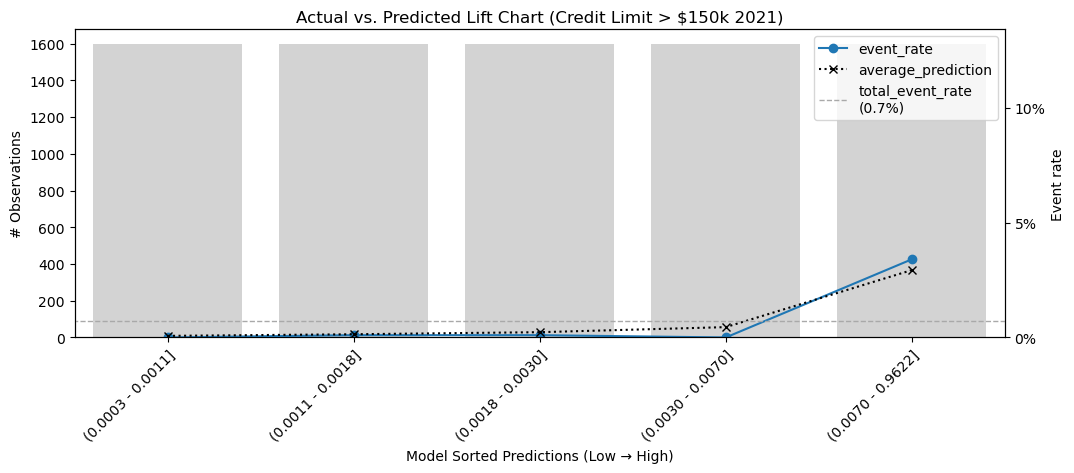

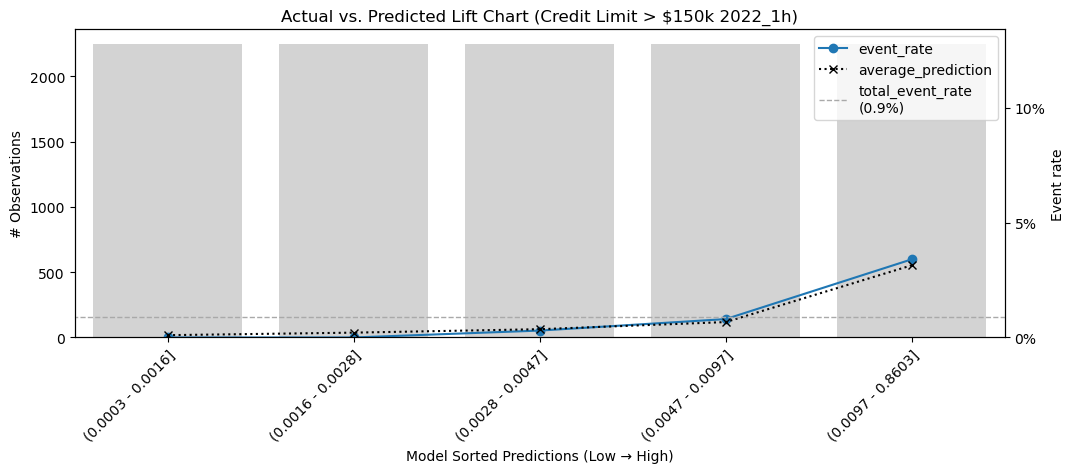

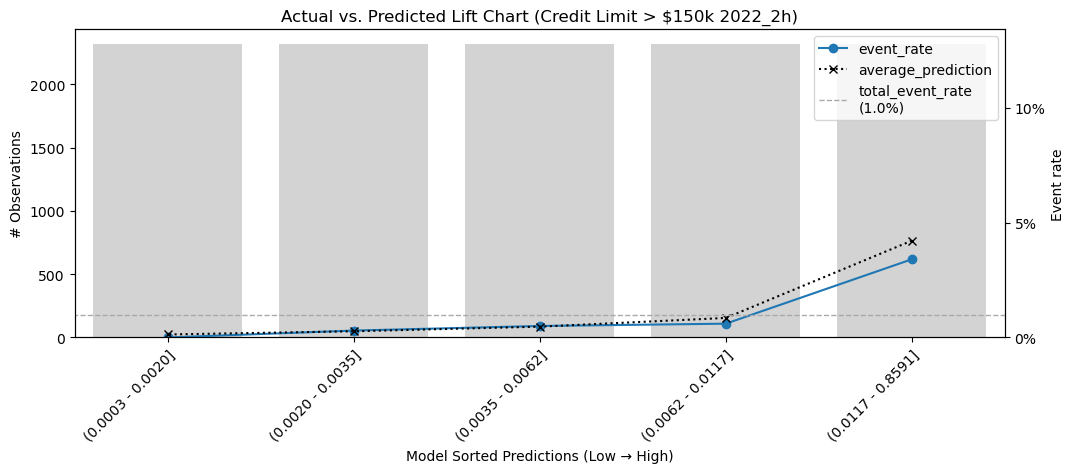

In [ ]:
over_150k_by_year = split_data_by_year(over_150k)

metrics_by_year(over_150k_by_year)

for y in over_150k_by_year:
    lift_curve(f'Credit Limit > $150k {y}', calculate_decile_table(over_150k_by_year[y], 5))

In [ ]:
def calculate_decile_table_cl_bucket_manual(binded, feature, buckets, n):
    # Using mapping_dict to create CR_LIMIT_BUCKET. Each bucket will be greater than the value in mapping_dict
    # binded["CR_LIMIT_BUCKET"] = binded[feature].map(mapping_dict)
    binded["TOTAL_EVENT_RATE"] =  binded["target"].mean()

    # binded = binded.sort_values("CR_LIMIT", ascending = False)
    binded["CR_LIMIT_BUCKET"] = pd.cut(binded["CR_LIMIT"], bins = buckets, labels = list(range(0, n, 1)))
    binded["TOTAL_EVENT_RATE"] =  binded["target"].mean()

    # Calculate the number of accounts and default accounts for each decile
    decile_df = binded.groupby("CR_LIMIT_BUCKET").agg(
        COUNT=("CR_LIMIT", "count"),
        DEFAULT=("target", "sum"),
        TOTAL_EVENT_RATE=("TOTAL_EVENT_RATE", "mean")
    ).reset_index()

    # Calculate the predicted probability range for each decile
    decile_df["CR_LIMIT_RANGE"] = binded.groupby("CR_LIMIT_BUCKET")["CR_LIMIT"].agg(["min", "max"]).apply(lambda x: f"{x['min']:,.0f} - {x['max']:,.0f}", axis=1).values
    decile_df["AVG_CL_LIMIT"] = binded.groupby("CR_LIMIT_BUCKET")["CR_LIMIT"].agg(["mean"]).values
    decile_df["AVG_CL_LIMIT"] = round(decile_df["AVG_CL_LIMIT"]).astype(int).apply(lambda x: "{:,}".format(x))

    # Calculate the predicted probability range for each decile
    decile_df["PROB_RANGE"] = binded.groupby("CR_LIMIT_BUCKET")["y_pred_proba"].agg(["min", "max"]).apply(lambda x: f"{x['min']:.3f} - {x['max']:.3f}", axis=1).values
    decile_df["AVG_PROB"] = binded.groupby("CR_LIMIT_BUCKET")["y_pred_proba"].agg(["mean"]).values
    decile_df["AVG_PROB"] = round(decile_df["AVG_PROB"], 4)

    # sort dataframes by decile
    decile_df = decile_df.sort_values(by="CR_LIMIT_BUCKET", ascending=False)

    # Calculate the cumulative number of accounts and default accounts
    decile_df["CUM_COUNT"] = round(decile_df["COUNT"].cumsum(),0)
    decile_df["CUM_DEFAULT"] = decile_df["DEFAULT"].cumsum()

    # Calculate the cumulative percentage of accounts and default accounts
    decile_df["CUM_PCT_COUNT"] = round(decile_df["CUM_COUNT"] / decile_df["COUNT"].sum() * 100, 3)
    decile_df["CUM_PCT_DEFAULT"] = round((decile_df["CUM_DEFAULT"] / decile_df["DEFAULT"].sum()), 3)

    # Calculate the default rate for each decile
    decile_df["DEFAULT_RATE"] = round((decile_df["DEFAULT"] / decile_df["COUNT"]), 3)

    # Calculate gain for each decile
    decile_df["GAIN"] = round((decile_df["CUM_DEFAULT"] / binded["target"].sum()), 3)

    # Calculate the lift for each decile
    decile_df["LIFT"] = round((decile_df["GAIN"]*100) / (decile_df["CUM_PCT_COUNT"]), 3)

    cols_to_display = [
        "CR_LIMIT_BUCKET",
        "CR_LIMIT_RANGE", 
        "AVG_CL_LIMIT", "PROB_RANGE", "AVG_PROB", "COUNT", "DEFAULT_RATE", "TOTAL_EVENT_RATE", "CUM_COUNT", "CUM_DEFAULT", "CUM_PCT_DEFAULT",
        "GAIN", "LIFT", "CUM_PCT_COUNT"
    ]

    decile_df = decile_df[cols_to_display]

    return decile_df


def cr_limit_lift_curve(name, df_binned):
    event_rate = df_binned["TOTAL_EVENT_RATE"].astype(float).mean()

    # Build event rate plot
    fig = plt.figure(figsize=(12,4))

    # Plot barplot containing number of observations
    plt.bar(df_binned.index, df_binned["COUNT"], color="lightgray")

    # Add ticks & laels to axis
    plt.xlabel("CR_LIMIT_BUCKET")
    plt.ylabel("# Observations")
    plt.xticks(df_binned.index, df_binned["CR_LIMIT_RANGE"], rotation=45, ha='right', rotation_mode='anchor')
    plt.title(f"{name}")

    # Mirror plot and add event rates
    plt2 = plt.twinx()
    plt2.set_ylabel("Event rate")
    plt2.set_ylim(ymin=0, ymax=df_binned["DEFAULT_RATE"].max() + 0.1)
    plt2.set_yticks(np.arange(0, df_binned["AVG_PROB"].max() + 0.1, step=0.02))
    plt2.plot(
        df_binned.index, df_binned["DEFAULT_RATE"], label="event_rate", marker="o"
    )

    # add average prediction
    plt2.plot(
        df_binned.index,
        df_binned["AVG_PROB"],
        label="average_prediction",
        marker="x",
        linestyle=":",
        color="black"
    )

    # Add global event rate as baseline
    plt2.plot(
        [min(df_binned.index) - 1, max(df_binned.index) + 1],
        [event_rate, event_rate],
        color="darkgrey",
        lw=1,
        linestyle="--",
        label=f"total_event_rate\n({'{:.1%}'.format(event_rate)})",
    )
    plt2.legend(loc=0)
    plt2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

    plt2.yaxis.grid(False)
    plt2.set_xlim([min(df_binned.index) - 0.5, max(df_binned.index) + 0.5])

    plt.show()

,CR_LIMIT_BUCKET,CR_LIMIT_RANGE,AVG_CL_LIMIT,PROB_RANGE,AVG_PROB,COUNT,DEFAULT_RATE,TOTAL_EVENT_RATE,CUM_COUNT,CUM_DEFAULT,CUM_PCT_DEFAULT,GAIN,LIFT,CUM_PCT_COUNT
9,9,"140,075 - 150,000","149,156",0.001 - 0.952,0.0222,17720,0.027,0.061511,17720,471,0.001,0.001,0.289,0.346
8,8,"120,042 - 140,000","129,863",0.000 - 0.982,0.0240,9840,0.032,0.061511,27560,783,0.002,0.002,0.372,0.538
7,7,"100,029 - 120,000","110,962",0.000 - 0.990,0.0234,17903,0.028,0.061511,45463,1279,0.004,0.004,0.451,0.887
6,6,"50,029 - 100,000","69,871",0.000 - 0.995,0.0256,130169,0.031,0.061511,175632,5283,0.017,0.017,0.496,3.428
5,5,"25,001 - 50,000","35,167",0.000 - 0.995,0.0289,278436,0.033,0.061511,454068,14565,0.046,0.046,0.519,8.863
4,4,"10,001 - 25,000","15,935",0.000 - 0.995,0.0373,798962,0.041,0.061511,1253030,47035,0.149,0.149,0.609,24.458
3,3,"5,000 - 10,000","7,450",0.000 - 0.996,0.0529,954438,0.059,0.061511,2207468,103803,0.329,0.329,0.764,43.088
2,2,"2,500 - 5,000","3,761",0.000 - 0.996,0.0546,1046862,0.060,0.061511,3254330,166748,0.529,0.529,0.833,63.522
1,1,"1,000 - 2,500","1,773",0.000 - 0.996,0.0607,1094171,0.066,0.061511,4348501,238550,0.757,0.757,0.892,84.879
0,0,"100 - 1,000",705,0.000 - 0.996,0.0879,774676,0.099,0.061511,5123177,315130,1.000,1.000,1.000,100.000


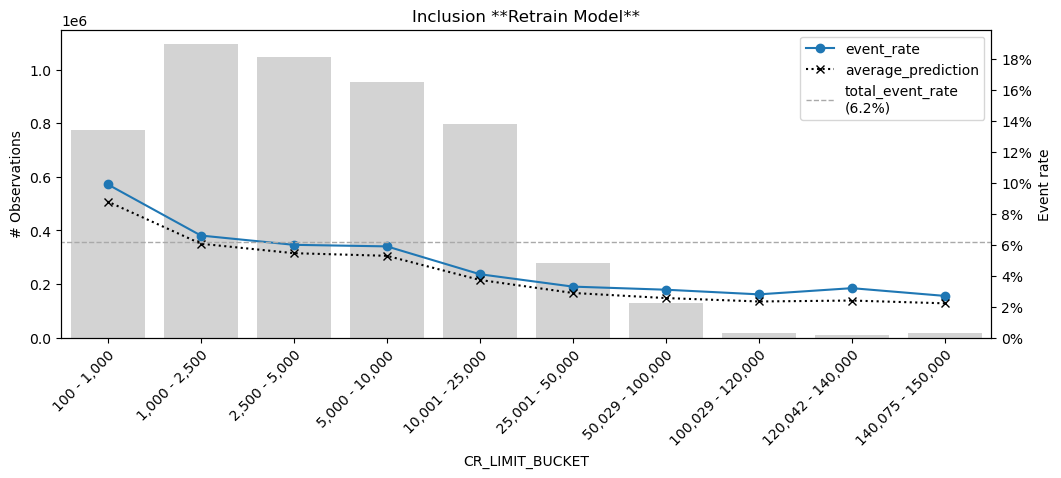

In [ ]:
mapping_dict = {0: 1000,
                1: 2500,
                3: 5000,
                4: 10000,
                5: 25000,
                6: 50000,
                7: 100000,
                8: 120000,
                9: 140000,
                # 10: 1000000,
                # 11: 2000000,
                12: np.inf
}

inclusion_buckets = [-np.inf]
n = len(mapping_dict)

for m in mapping_dict:
    inclusion_buckets.append(mapping_dict[m])

inclusion_decile_manual = calculate_decile_table_cl_bucket_manual(incl, 'y_pred_proba', inclusion_buckets, n)
display(inclusion_decile_manual)

cr_limit_lift_curve('Inclusion **Retrain Model**', inclusion_decile_manual)

In [ ]:
mapping_dict = {0: 1000,
                1: 2500,
                3: 5000,
                4: 10000,
                5: 25000,
                6: 50000,
                7: 100000,
                8: 150000,
                9: 500000,
                10: 1000000,
                11: 2000000,
                12: np.inf
}

gov_buckets = [-np.inf]
n = len(mapping_dict)

for m in mapping_dict:
    gov_buckets.append(mapping_dict[m])

gov_decile_manual = calculate_decile_table_cl_bucket_manual(gov, 'y_pred_proba', gov_buckets, n)
display(gov_decile_manual)

cr_limit_lift_curve('Government **Retrain Model**', gov_decile_manual)

NameError: name 'calculate_decile_table_cl_bucket_manual' is not defined

In [ ]:
for y in gov_by_year:
    cr_limit_lift_curve(f'Credit Limit = $150k {y}', calculate_decile_table_cl_bucket_manual(gov_by_year[y], 'y_pred_proba', gov_buckets, 5))

,CR_LIMIT_BUCKET,CR_LIMIT_RANGE,AVG_CL_LIMIT,PROB_RANGE,AVG_PROB,COUNT,DEFAULT_RATE,TOTAL_EVENT_RATE,CUM_COUNT,CUM_DEFAULT,CUM_PCT_DEFAULT,GAIN,LIFT,CUM_PCT_COUNT
11,11,"2,272,580 - 65,000,000","12,721,622",0.001 - 0.092,0.0177,356,0.000,0.009753,356,0,0.000,0.000,0.000,0.760
10,10,"1,065,000 - 2,000,000","1,244,153",0.000 - 0.223,0.0162,4539,0.000,0.009753,4895,0,0.000,0.000,0.000,10.446
9,9,"510,000 - 1,000,000","620,353",0.001 - 0.319,0.0143,73,0.000,0.009753,4968,0,0.000,0.000,0.000,10.602
8,8,"150,767 - 500,000","253,820",0.001 - 0.598,0.0204,433,0.000,0.009753,5401,0,0.000,0.000,0.000,11.526
7,7,"100,733 - 150,000","128,234",0.001 - 0.276,0.0116,449,0.000,0.009753,5850,0,0.000,0.000,0.000,12.484
6,6,"50,200 - 100,000","71,508",0.000 - 0.679,0.0157,1285,0.016,0.009753,7135,20,0.044,0.044,0.289,15.227
5,5,"25,100 - 50,000","35,829",0.000 - 0.979,0.0166,2656,0.007,0.009753,9791,39,0.085,0.085,0.407,20.895
4,4,"10,100 - 25,000","16,237",0.000 - 0.919,0.0148,6659,0.006,0.009753,16450,79,0.173,0.173,0.493,35.105
3,3,"5,040 - 10,000","7,468",0.000 - 0.980,0.0171,8709,0.004,0.009753,25159,110,0.241,0.241,0.449,53.691
2,2,"2,550 - 5,000","3,858",0.001 - 0.860,0.0180,8616,0.010,0.009753,33775,200,0.438,0.438,0.608,72.078


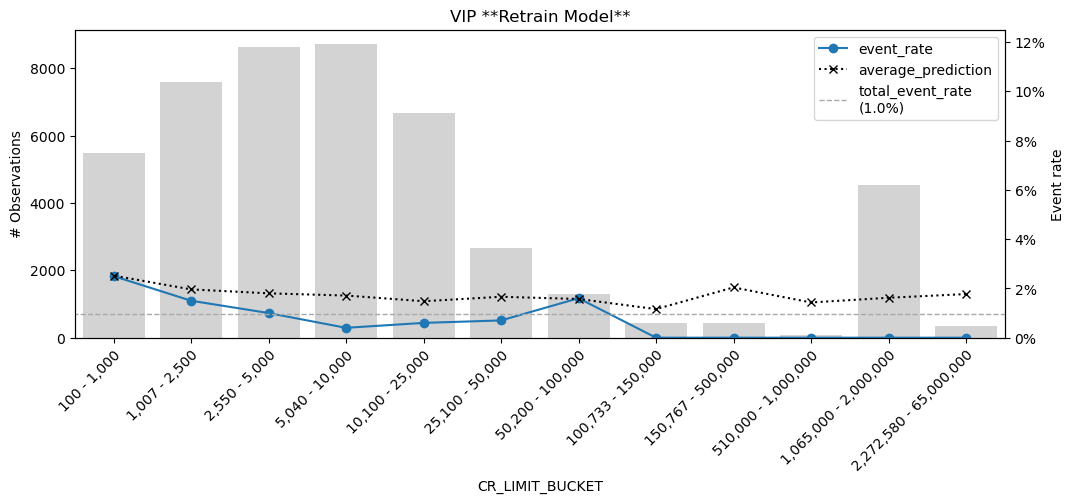

In [ ]:
mapping_dict = {0: 1000,
                1: 2500,
                3: 5000,
                4: 10000,
                5: 25000,
                6: 50000,
                7: 100000,
                8: 150000,
                9: 500000,
                10: 1000000,
                11: 2000000,
                12: np.inf
}

vip_buckets = [-np.inf]
n = len(mapping_dict)

for m in mapping_dict:
    vip_buckets.append(mapping_dict[m])

vip_decile_manual = calculate_decile_table_cl_bucket_manual(vip, 'y_pred_proba', vip_buckets, n)
display(vip_decile_manual)

cr_limit_lift_curve('VIP **Retrain Model**', vip_decile_manual)

,CR_LIMIT_BUCKET,CR_LIMIT_RANGE,AVG_CL_LIMIT,PROB_RANGE,AVG_PROB,COUNT,DEFAULT_RATE,TOTAL_EVENT_RATE,CUM_COUNT,CUM_DEFAULT,CUM_PCT_DEFAULT,GAIN,LIFT,CUM_PCT_COUNT
10,10,"2,230,000 - 10,500,000","5,748,869",0.000 - 0.025,0.0015,107,0.000,0.00093,107,0,0.000,0.000,0.000,0.042
9,9,"1,007,300 - 2,000,000","1,452,425",0.000 - 0.005,0.0011,75,0.000,0.00093,182,0,0.000,0.000,0.000,0.071
8,8,"151,910 - 1,000,000","338,832",0.000 - 0.023,0.0008,3117,0.000,0.00093,3299,0,0.000,0.000,0.000,1.294
7,7,"100,100 - 150,000","132,824",0.000 - 0.032,0.0008,5957,0.000,0.00093,9256,0,0.000,0.000,0.000,3.631
6,6,"50,040 - 100,000","72,128",0.000 - 0.126,0.0008,12458,0.000,0.00093,21714,0,0.000,0.000,0.000,8.518
5,5,"25,000 - 50,000","35,803",0.000 - 0.376,0.0011,21678,0.000,0.00093,43392,10,0.042,0.042,0.247,17.021
4,4,"10,002 - 25,000","16,307",0.000 - 0.569,0.0013,47366,0.000,0.00093,90758,20,0.084,0.084,0.236,35.602
3,3,"5,001 - 10,000","7,444",0.000 - 0.769,0.0018,49594,0.001,0.00093,140352,54,0.228,0.228,0.414,55.056
2,2,"2,500 - 5,000","3,747",0.000 - 0.797,0.0019,49383,0.001,0.00093,189735,99,0.418,0.418,0.562,74.427
1,1,"1,004 - 2,500","1,799",0.000 - 0.903,0.0022,43225,0.001,0.00093,232960,155,0.654,0.654,0.716,91.383


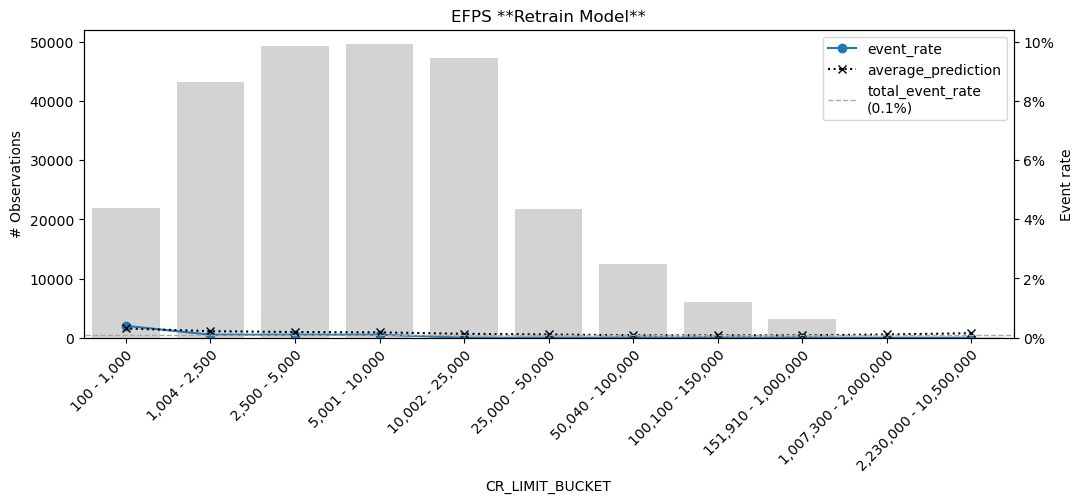

In [ ]:
mapping_dict = {0: 1000,
                1: 2500,
                3: 5000,
                4: 10000,
                5: 25000,
                6: 50000,
                7: 100000,
                8: 150000,
                9: 1000000,
                # 10: 1500000,
                11: 2000000,
                12: np.inf
}

efps_buckets = [-np.inf]
n = len(mapping_dict)

for m in mapping_dict:
    efps_buckets.append(mapping_dict[m])

efps_decile_manual = calculate_decile_table_cl_bucket_manual(df_list['efps'], 'y_pred_proba', efps_buckets, n)
display(efps_decile_manual)

cr_limit_lift_curve('EFPS **Retrain Model**', efps_decile_manual)

,CR_LIMIT_BUCKET,CR_LIMIT_RANGE,AVG_CL_LIMIT,PROB_RANGE,AVG_PROB,COUNT,DEFAULT_RATE,TOTAL_EVENT_RATE,CUM_COUNT,CUM_DEFAULT,CUM_PCT_DEFAULT,GAIN,LIFT,CUM_PCT_COUNT
7,7,"10,028,000 - 30,000,000","16,775,852",0.002 - 0.252,0.0213,89,0.157,0.008765,89,14,0.052,0.052,17.993,0.289
6,6,"2,008,961 - 10,000,000","4,350,210",0.000 - 0.500,0.0147,672,0.022,0.008765,761,29,0.107,0.107,4.332,2.470
5,5,"1,000,600 - 2,000,000","1,378,032",0.000 - 0.348,0.0055,5901,0.000,0.008765,6662,30,0.111,0.111,0.513,21.626
4,4,"501,700 - 1,000,000","720,989",0.000 - 0.876,0.0101,4228,0.013,0.008765,10890,85,0.315,0.315,0.891,35.351
3,3,"400,596 - 500,000","464,525",0.001 - 0.765,0.0154,1225,0.009,0.008765,12115,96,0.356,0.356,0.905,39.328
2,2,"300,398 - 400,000","346,738",0.000 - 0.503,0.0079,2915,0.009,0.008765,15030,121,0.448,0.448,0.918,48.791
1,1,"200,100 - 300,000","250,889",0.000 - 0.962,0.0075,8411,0.007,0.008765,23441,177,0.656,0.656,0.862,76.095
0,0,"150,163 - 200,000","185,913",0.000 - 0.927,0.0146,7364,0.013,0.008765,30805,270,1.000,1.000,1.000,100.000


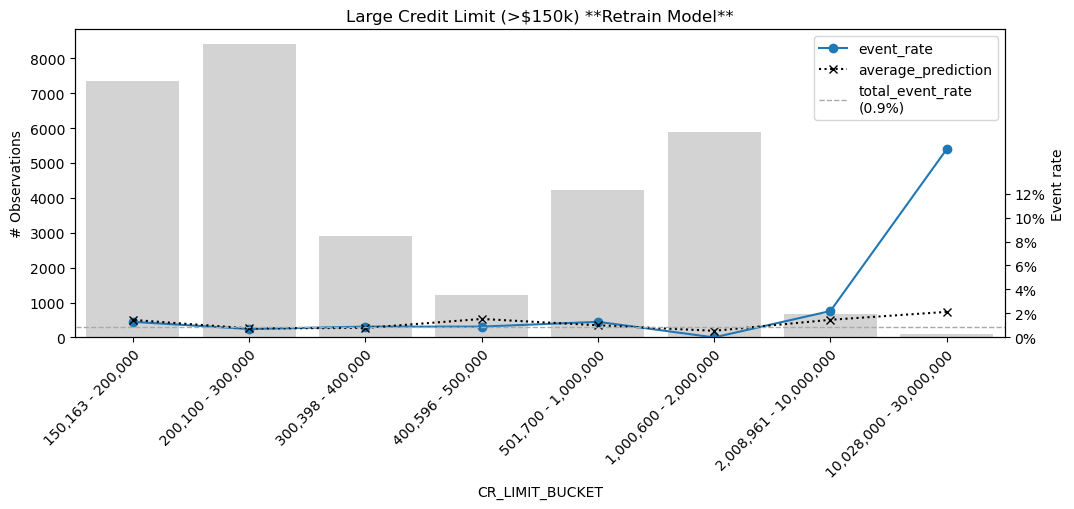

In [ ]:
mapping_dict = {0: 200000,
                # 1: 200000,
                2: 300000,
                3: 400000,
                4: 500000,
                # 5: 600000,
                # 6: 700000,
                # 7: 800000,
                # 8: 900000,
                9: 1000000,
                10: 2000000,
                11: 10000000,
                12: np.inf
}

large_credit_limit_buckets = [-np.inf]
n = len(mapping_dict)

for m in mapping_dict:
    large_credit_limit_buckets.append(mapping_dict[m])

large_credit_limit_decile_manual = calculate_decile_table_cl_bucket_manual(over_150k, 'y_pred_proba', large_credit_limit_buckets, n)
display(large_credit_limit_decile_manual)

cr_limit_lift_curve('Large Credit Limit (>$150k) **Retrain Model**', large_credit_limit_decile_manual)

In [ ]:
def roc_auc_pr_auc_plot(p):
    # Plot ROC-AUC and PR-AUC side by side
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    lines = plt.plot(fpr[p], tpr[p], color='#1f77b4', lw=2, label=f'proba_1 (ROC-AUC = {roc_auc[p]:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=.5, linestyle='--')
    labels = [l.get_label() for l in lines]
    # plot legend outside of plot
    plt.legend(lines, labels, loc='lower right')
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.title('Receiver Operating Characteristic (ROC) AUC Curve' , fontsize=12)

    plt.subplot(1, 2, 2)
    lines2 = plt.step(recall[p], precision[p], color='#ffc08a', where='post', label=f'proba_1 (PR-AUC = {pr_auc[p]:.2f})')
    labels2 = [l.get_label() for l in lines2]
    # move legend to lower center outside of plot
    plt.legend(lines2, labels2, loc='lower left')
    plt.xlabel('Recall', fontsize=10)
    plt.ylabel('Precision', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.title(f'Precision-Recall AUC Curve', fontsize=12)

    # plt.tight_layout()
    plt.show()

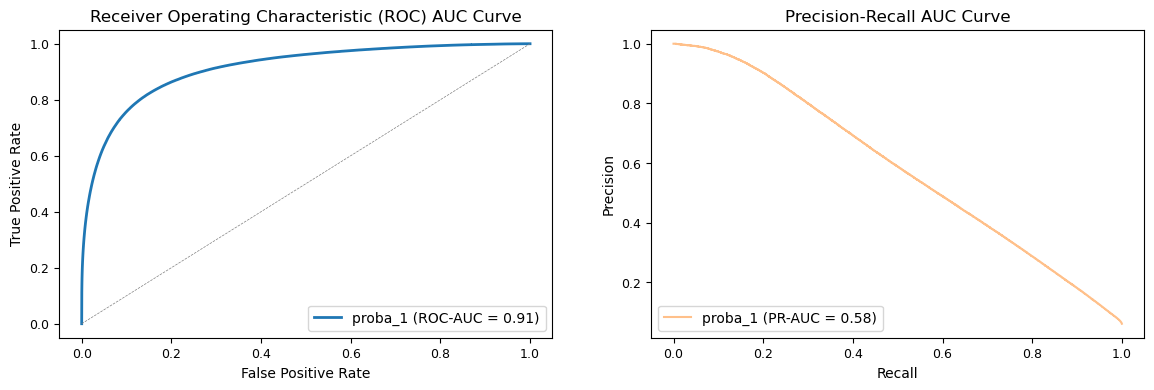

In [ ]:
roc_auc_pr_auc_plot('Inclusion')

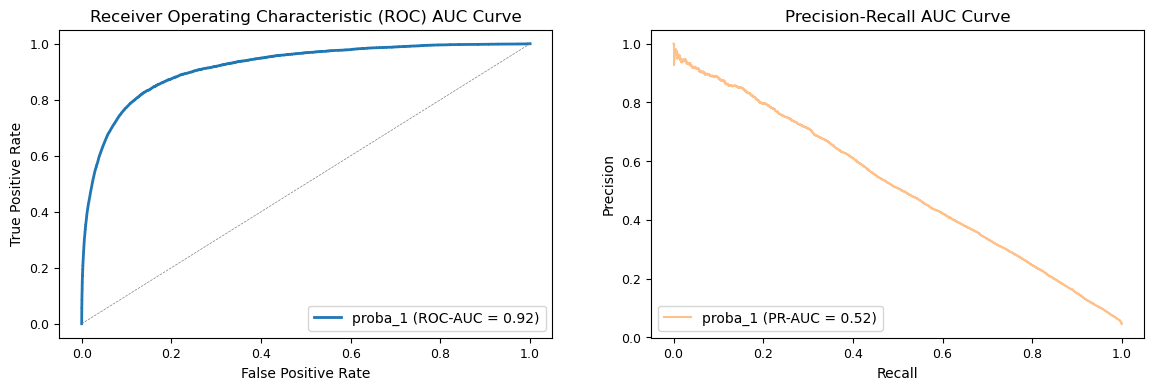

In [ ]:
roc_auc_pr_auc_plot('GOV')

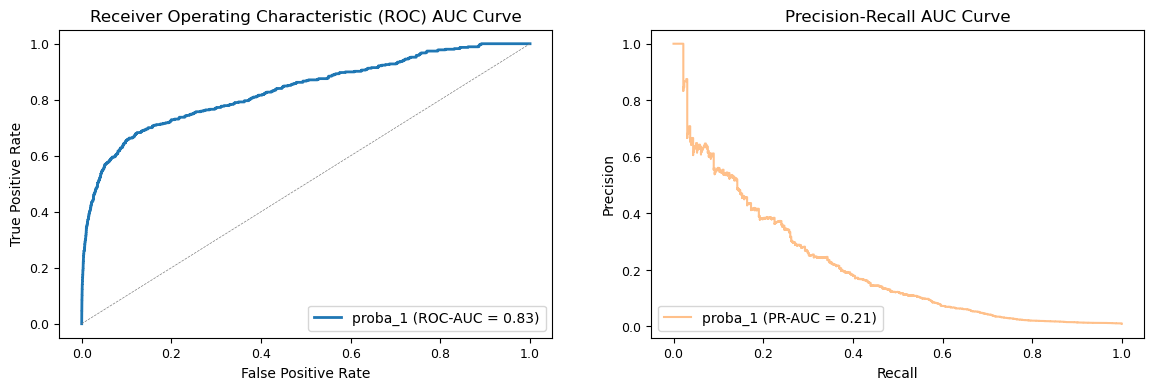

In [ ]:
roc_auc_pr_auc_plot('VIP')

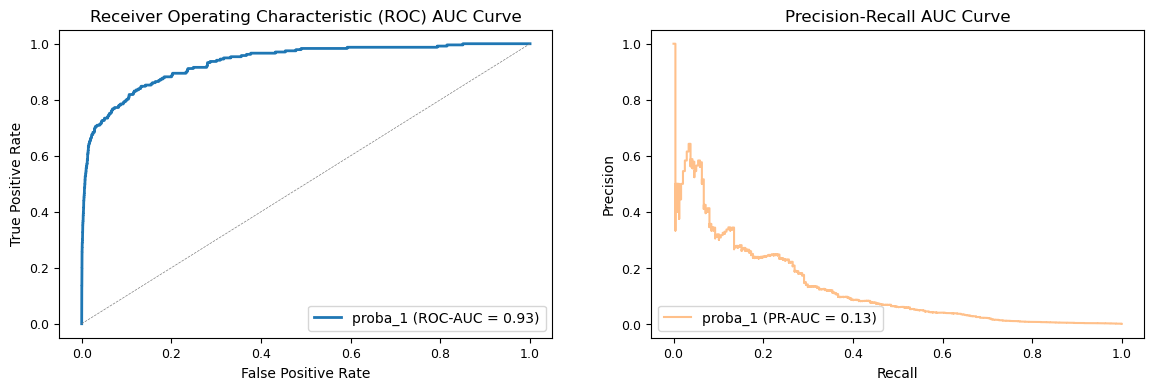

In [ ]:
roc_auc_pr_auc_plot('EFPS')

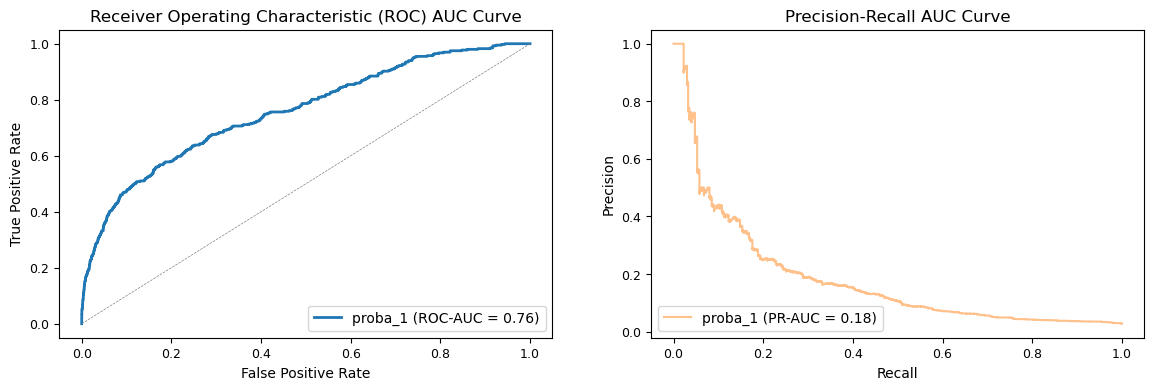

In [ ]:
roc_auc_pr_auc_plot('150k Credit Limit')

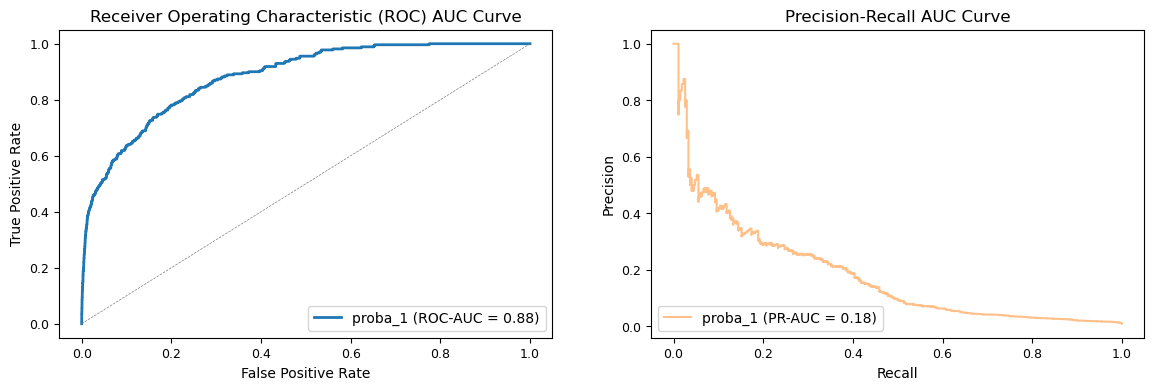

In [ ]:
roc_auc_pr_auc_plot('Large Credit Limit')

In [ ]:
 # change ref_date to date
df_combine['REF_DATE'] = pd.to_datetime(df_combine['REF_DATE'], format='%Y-%m-%d %H:%M:%S', utc=True)

# create datafram call df_combine_2021 which have ref_date in 2021
df_combine_2022 = df_combine[df_combine['REF_DATE'].dt.year == 2022]
print(df_combine_2022.shape)

(4333771, 30)


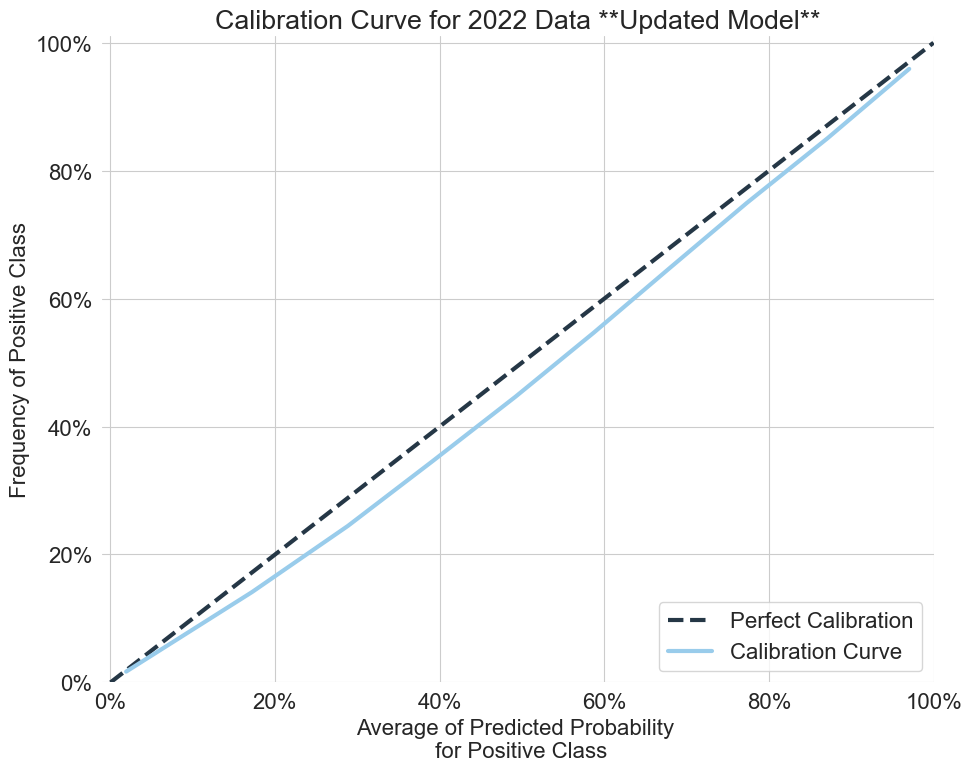

In [ ]:
import matplotlib
import seaborn as sns
from sklearn.calibration import calibration_curve

## Build an AUC Plot
fig, ax = plt.subplots(figsize=(10,8))
lw = 3
matplotlib.rc('font', **{'size': 16})
plt.rcParams["hatch.linewidth"]=1.5

sns.set_style("whitegrid")

wx_red = (153/255,204/255,235/255)
wx_gray = (37/255,55/255,70/255)
wx_green = (37/255,55/255,70/255)

val_prob_true, val_prob_pred = calibration_curve(
    df_combine_2022['target'].astype(int),
    df_combine_2022['y_pred_proba'], 
    n_bins = 10
)

plt.plot([0, 1], [0, 1], color=wx_gray, lw=lw, linestyle="--", label='Perfect Calibration')
plt.plot(
    val_prob_true,
    val_prob_pred,
    color=wx_red,
    lw=lw,
    label=f"Calibration Curve",
)

sns.despine(
    top=True,
    bottom=True,
    left=True,
    right=True
)

ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0))

#ax.set_xticklabels([1, 20, 40, 60, 80, 100])

plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.01])
plt.xlabel("Average of Predicted Probability \n for Positive Class")
plt.ylabel("Frequency of Positive Class")
plt.title("Calibration Curve for 2022 Data **Updated Model**")
plt.legend(loc="lower right")
plt.tight_layout()